# Problem Statement

Differentiate between subreddit posts more commonly associated with confessions or relationships.

## Importing Libraries

In [34]:
import numpy as np
import requests
import pandas as pd
import time
import random
import regex as re

import matplotlib.pyplot as plt

from nltk.corpus import stopwords # Import the stop word list
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize

from sklearn.metrics import classification_report, roc_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.neighbors import  KNeighborsClassifier 

import warnings
from psaw import PushshiftAPI

# After the imports
warnings.filterwarnings(action='ignore')

# Data Acquisition

In [2]:
urls = {'confessions' : 'https://www.reddit.com/r/confessions.json', 
        'relationships' : 'https://www.reddit.com/r/relationships.json'}

Scrap data using the PushShiftAPI to extract more than 1000 posts per subreddit to overcome Reddit's imposed limitation.

In [4]:
%time

api = PushshiftAPI()
confessions = pd.DataFrame(list(api.search_submissions(subreddit='confessions',
                                         filter=['author','title','subreddit','selftext'],
                                         limit=5000)))
relationships = pd.DataFrame(list(api.search_submissions(subreddit='relationships',
                                         filter=['author','title','subreddit','selftext'],
                                         limit=5000)))

# store the scrapped data.
confessions.to_csv('./data/confessions.csv')
relationships.to_csv('./data/relationships.csv')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.34 µs


In [ ]:
# %time
## Scrapper using conventional methods
# def reddit_scrapper(key,url,n_iterations=10):
    
#     #load_previous_file
#     prev_posts = pd.read_csv('./data/' + str(key) + '.csv')
#     print("Number of records loaded : {}".format(prev_posts.shape[0]))
    
#     posts = []
#     after = None

#     for a in range(n_iterations):
#         if after == None:
#             current_url = url + '?limit=100'
#         else:
#             current_url = url + '?after=' + after + '&limit=100'
#         print(current_url)
#         res = requests.get(current_url, headers={'User-agent': 'Falcon 2.0'})

#         if res.status_code != 200:
#             print('Status error', res.status_code)
#             break

#         current_dict = res.json()
#         current_posts = [p['data'] for p in current_dict['data']['children']]
#         posts.extend(current_posts)
#         after = current_dict['data']['after']

#         # generate a random sleep duration to look more 'natural'
#         sleep_duration = random.randint(2,6)
        
#         time.sleep(sleep_duration)
    
#     #add_to_existing
#     posts = pd.DataFrame(posts)
#     posts_df = posts.append(prev_posts,ignore_index=True)
#     #remove duplicates
#     #posts_df.drop_duplicates(inplace=True)
#     print("Number of records stored : {}".format(posts_df.shape[0]))
#     posts_df.to_csv('./data/' + str(key) + '.csv', index = False)

### Load in Data

In [35]:
df_relationships = pd.read_csv('./data/relationships.csv')
df_confessions = pd.read_csv('./data/confessions.csv')

## Data Cleaning

We create a `filter_columns` function that filters out the title, self text and subreddit name (our target)

In [36]:
def filter_columns(df):
    columns_to_retain = ['title','selftext','subreddit','author']
    return df[columns_to_retain]

In [37]:
df_relationships_clean = filter_columns(df_relationships)
df_conf_clean = filter_columns(df_confessions)

In [38]:
display(df_relationships_clean.count())
display(df_conf_clean.count())

title        5000
selftext     4984
subreddit    5000
author       5000
dtype: int64

title        5000
selftext     4261
subreddit    5000
author       5000
dtype: int64

We can observe that the classes are imbalanced. For our classification dataset, we will aim to have a 1:1 class balance.

In [39]:
df_relationships_clean.head()

,title,selftext,subreddit,author
0,Hi I'm here to find my friends without anybody...,NaN,relationships,0100100001010000
1,My (M31) mind might be broken when i thi k abo...,[removed],relationships,obviousThrowaway274
2,How do I (26m) apologize to my ex (25f) in a d...,"Long story short, we broke up 4 months ago and...",relationships,Throwitallaway73734
3,Do you believe it's better to solve an argumen...,[removed],relationships,EvenKealed
4,Am i broken?,[removed],relationships,obviousThrowaway274


In [40]:
df_conf_clean.head()

,title,selftext,subreddit,author
0,Thought a girl was giving me a quarter and the...,"So, this was back in 2nd grade. It's a normal ...",confessions,jessthatrandomperson
1,How can I enjoy my last few days?,I am going to die very soon. \n\nI am terrifie...,confessions,throwaway948118
2,I am a narcissistic asshole and I know it and ...,I am basically just a manipulative horrible pe...,confessions,royjorbison
3,I use Reddit as an audience for my puns,I can't go ten sentences without thinking of a...,confessions,anikdylan27
4,I'm sorry for being an asshole last night,"To the guy I met last night, who's name escape...",confessions,roodeeMental


Prior to this, we may wish to remove posts that have 'Moderator' as an author to train our model on more 'authentic' posts.

In [41]:
df_relationships_clean.loc[:,'author'] = df_relationships_clean.author.map(lambda x : x.lower())
df_conf_clean.loc[:,'author'] = df_conf_clean.author.map(lambda x : x.lower())

In [42]:
df_relationships_clean = df_relationships_clean[~df_relationships_clean.author.str.contains('moderator')]
df_conf_clean = df_conf_clean[~df_conf_clean.author.str.contains('moderator')]

In [43]:
df_relationships_clean.isna().sum()

title         0
selftext     16
subreddit     0
author        0
dtype: int64

In [44]:
df_conf_clean.isna().sum()

title          0
selftext     739
subreddit      0
author         0
dtype: int64

We also observe empty selftext in both subreddits. we shall drop rows with empty selftext.

In [45]:
df_relationships_clean = df_relationships_clean.dropna(axis=0)
df_conf_clean = df_conf_clean.dropna(axis=0)

Ensure only posts with selftext more than 10words are selected.

In [46]:
df_relationships_clean ['selftext_len'] = df_relationships_clean .selftext.map(lambda x: len(x.split()))
df_relationships_clean  = df_relationships_clean [df_relationships_clean .selftext_len > 10]
df_conf_clean['selftext_len'] = df_conf_clean.selftext.map(lambda x: len(x.split()))
df_conf_clean = df_conf_clean[df_conf_clean.selftext_len > 10]

In [47]:
df_relationships_clean.drop_duplicates(inplace=True)
df_conf_clean.drop_duplicates(inplace=True)

In [48]:
display(df_relationships_clean.count())
display(df_conf_clean.count())

title           2925
selftext        2925
subreddit       2925
author          2925
selftext_len    2925
dtype: int64

title           3893
selftext        3893
subreddit       3893
author          3893
selftext_len    3893
dtype: int64

In [49]:
# check posts with [deleted] or [removed]
print("[deleted] Counts:")
display((df_relationships_clean.title == '[deleted]').value_counts())
display((df_conf_clean.title == '[deleted]').value_counts())
print("[removed] Counts:")
display((df_relationships_clean.title == '[removed]').value_counts())
display((df_conf_clean.title == '[removed]').value_counts())

[deleted] Counts:


False    2925
Name: title, dtype: int64

False    3893
Name: title, dtype: int64

[removed] Counts:


False    2925
Name: title, dtype: int64

False    3893
Name: title, dtype: int64

We will then randomly select 2900 of each class since quite a significant number were from a moderator-author as well as empty text.

In [50]:
subset_relationships_clean = df_relationships_clean.sample(n=2900,random_state=666)
subset_conf_clean = df_conf_clean.sample(n=2900,random_state=666)

In [51]:
# combine both subsets into a DF
df_pre = subset_relationships_clean.append(subset_conf_clean,ignore_index=True)
df_pre.subreddit.value_counts()

relationships    2900
confessions      2900
Name: subreddit, dtype: int64

In [52]:
# create target class columns 0 = relationships, 1 = confessions 

df_pre['label'] = df_pre.subreddit.map({'relationships':0,'confessions':1}).astype('int')
df_pre.head()

,title,selftext,subreddit,author,selftext_len,label
0,I (F18) am questioning the intentions of a ran...,My lovely (quite attractive) new boyfriend (M1...,relationships,boterbabbelaartje,334,0
1,Jealousy,My boyfriend(29m) and I(30f) have been togethe...,relationships,taramarie87,103,0
2,I [28F] wants sex all the time. I've made this...,"Lately, I've been wanting more sex. To have se...",relationships,missionblueberry,236,0
3,I [32m] am having issues with jealousy with my...,Hooo boy. Here we go. \n\nMy wife and I have b...,relationships,dcsrm,438,0
4,Is my girlfriend into wedgies?,My girlfriend (F 21yrs old) and I (M 32yrs old...,relationships,davidsardinas36,73,0


Ensure formatting of text by:
- Converting all to lower cases
- removing groups of words in parantheses
- remove line breaks
- removing special characters


In [53]:
# convert the stop words to a set.
stops = set(stopwords.words('english'))

def clean_text(text):
    #01 convert titles, selftext into lowercase
    lower_text = text.lower()
    #02 remove brackets and parenthesis from the title and selftext.
    no_br_paret_text = re.sub(r'\(.+?\)|\[.+?\]',' ',str(lower_text))
    #03 remove special characters
    removed_special = re.sub(r'[^0-9a-zA-Z ]+',' ',str(no_br_paret_text))
    #04 remove xamp200b
    remove_xamp200b = re.sub(r'ampx200b',' ',str(removed_special))
    #05 remove digits
    result = re.sub(r'\d+', '', remove_xamp200b).split()
    #06 split into individual words
    meaningful_words = [w for w in result if not w in stops]
    
    #07 Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))


In [54]:
df[['title','selftext']] = df_pre[['title','selftext']].applymap(clean_text)
df.head()

,title,selftext,subreddit,author,selftext_len,label
0,questioning intentions random new girl asked b...,lovely new boyfriend told girl cig outside sch...,relationships,boterbabbelaartje,334,0
1,jealousy,boyfriend together almost years two beautiful ...,relationships,taramarie87,103,0
2,wants sex time made known whose,lately wanting sex sex time bit back story rel...,relationships,missionblueberry,236,0
3,issues jealousy wife stage acting,hooo boy go wife married years coming ups down...,relationships,dcsrm,438,0
4,girlfriend wedgies,girlfriend together months used phone look som...,relationships,davidsardinas36,73,0


In [55]:
pd.DataFrame(data=zip(df_pre['selftext'],df['selftext']),columns=['pre','post']).head(5)

,pre,post
0,My lovely (quite attractive) new boyfriend (M1...,lovely new boyfriend told girl cig outside sch...
1,My boyfriend(29m) and I(30f) have been togethe...,boyfriend together almost years two beautiful ...
2,"Lately, I've been wanting more sex. To have se...",lately wanting sex sex time bit back story rel...
3,Hooo boy. Here we go. \n\nMy wife and I have b...,hooo boy go wife married years coming ups down...
4,My girlfriend (F 21yrs old) and I (M 32yrs old...,girlfriend together months used phone look som...


## Data Exploration

Split title and self text into two classifiers where the output of title_classifier and self_text classifier would provide indication of subreddit belonging.

In [56]:
#split titles, and self text into seperate df

df_title = df[['title','label']]
df_selftext = df[['selftext','label']]

In [57]:
def get_freq_words(sparse_counts, columns):
    # X_all is a sparse matrix, so sum() returns a 'matrix' datatype ...
    #   which we then convert into a 1-D ndarray for sorting
    word_counts = np.asarray(sparse_counts.sum(axis=0)).reshape(-1)

    # argsort() returns smallest first, so we reverse the result
    largest_count_indices = word_counts.argsort()[::-1]

    # pretty-print the results! Remember to always ask whether they make sense ...
    freq_words = pd.Series(word_counts[largest_count_indices], 
                           index=columns[largest_count_indices])

    return freq_words

In [58]:
# Let's use the CountVectorizer to count words for us for each class

# create mask

X_1 = df_selftext[df_selftext['label'] == 1]
X_0 = df_selftext[df_selftext['label'] == 0]

cvt      =  CountVectorizer(ngram_range=(1,1),stop_words='english')
X_1_all    =  cvt.fit_transform(X_1['selftext'])
X_0_all    =  cvt.fit_transform(X_0['selftext'])
columns_1  =  np.array(cvt.get_feature_names())          # ndarray (for indexing below)
columns_0  =  np.array(cvt.get_feature_names())    

In [59]:
freq_words_1 = get_freq_words(X_1_all, columns_1)
freq_words_0 = get_freq_words(X_0_all, columns_0)
print('Confessions:')
display(freq_words_1[:10])
print('Relationships:')
display(freq_words_0[:10])

Confessions:


landlord       3063
msg            2325
jeopardise     1979
teachings      1721
eyes           1674
pur            1506
user           1438
overworking    1405
generic        1133
lacking        1109
dtype: int64

Relationships:


like            6690
time            4761
know            4694
want            4630
really          4235
feel            4000
relationship    3744
said            3245
things          3070
told            2999
dtype: int64

### Split selftext 

In [60]:
X_text = df_selftext['selftext']
y_text = df_selftext['label']

X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(X_text,y_text,stratify=y_text) 

# Data Modeling

In [61]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

Use Naive Bayers model - MultinomialNB as there are multiple nominal features in the form of the various tokens.

In [54]:
classifiers = []
vectorizers = [('cvec', CountVectorizer(stop_words='english',tokenizer=LemmaTokenizer())),
              ('tfvec', TfidfVectorizer(stop_words='english',tokenizer=LemmaTokenizer()))]

for vectorizer in vectorizers:
    bayes_pipe = Pipeline([
            (vectorizer),
            ('mnb', MultinomialNB())
        ])
    scores = cross_val_score(bayes_pipe, X_text_train, y_text_train,cv=5,verbose=1)
    b = bayes_pipe.fit(X_text_train, y_text_train)
    y_pred = b.predict(X_text_test)
    print(classification_report(y_text_test, y_pred, target_names=['class 0','class 1']))
    print('Cross val score for mnb classifier using {} vectorizer is {}'.format(vectorizer[0],scores))
    print('Accuracy score for mnb classifier using {} vectorizer is {}'.format(vectorizer[0],bayes_pipe.score(X_text_test, y_text_test)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   17.6s finished


              precision    recall  f1-score   support

     class 0       0.76      0.96      0.85       725
     class 1       0.95      0.69      0.80       725

    accuracy                           0.82      1450
   macro avg       0.85      0.82      0.82      1450
weighted avg       0.85      0.82      0.82      1450

Cross val score for mnb classifier using cvec vectorizer is [0.8183908  0.81609195 0.84252874 0.83908046 0.81724138]
Accuracy score for mnb classifier using cvec vectorizer is 0.8248275862068966


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.7s finished


              precision    recall  f1-score   support

     class 0       0.65      0.99      0.79       725
     class 1       0.98      0.47      0.64       725

    accuracy                           0.73      1450
   macro avg       0.82      0.73      0.71      1450
weighted avg       0.82      0.73      0.71      1450

Cross val score for mnb classifier using tfvec vectorizer is [0.71149425 0.72298851 0.72528736 0.72873563 0.69425287]
Accuracy score for mnb classifier using tfvec vectorizer is 0.7310344827586207


Thus the recall scores for multonomial NB with countvectorizer seems to provide higher recall when compared to the tfidf vectorizer.

In [55]:
# store predicted_proba scores for later evaluation under ROC curve
def generate_roc(pipeline):

    b = pipeline.fit(X_text_train, y_text_train)
    fpr, tpr, _ = roc_curve(y_text_test, b.predict_proba(X_text_test)[:,1],pos_label=1)
    
    return [fpr,tpr]


In [56]:
cv_bayes_pipe = Pipeline([
            (vectorizers[0]),
            ('mnb', MultinomialNB())
        ])

cv_nb_roc = generate_roc(cv_bayes_pipe)


In [57]:
tfidf_bayes_pipe = Pipeline([
            (vectorizers[1]),
            ('mnb', MultinomialNB())
        ])

tfidf_nb_roc = generate_roc(tfidf_bayes_pipe)

## Pipeline for Logistic Regression

In [58]:
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words='english',tokenizer=LemmaTokenizer())),
    ('lr', LogisticRegression(solver='saga',max_iter=300))
])

#### Obtain hyperparameters for our vectorizer and logistic regressor.

In [59]:
pipe_params = {
    'cvec__max_features': [2500, 3000, 3500],
    'cvec__ngram_range': [(1,1), (1,2)],
    'lr__penalty' : ['elasticnet'],
    'lr__C' : np.arange(0.1,1,0.1),
    'lr__l1_ratio' : np.arange(0,1.1,0.2)
}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5,verbose=1,n_jobs=-1)
gs.fit(X_text_train, y_text_train)
print(gs.best_score_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 31.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 51.9min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 71.1min finished


0.9154022988505747


In [60]:
gs.best_params_

{'cvec__max_features': 2500,
 'cvec__ngram_range': (1, 1),
 'lr__C': 0.1,
 'lr__l1_ratio': 1.0,
 'lr__penalty': 'elasticnet'}

In [61]:
gs.best_estimator_.score(X_text_test,y_text_test)

0.9186206896551724

In [89]:
# try model on title
optimal_pipe = Pipeline([
            ('cvec', CountVectorizer(tokenizer=LemmaTokenizer(),max_features=2500,ngram_range=(1,1))),
            ('lr', LogisticRegression(solver='saga',max_iter=300,C=0.1,l1_ratio=1.0,penalty='elasticnet'))
        ])

In [90]:
X_title = df_title['title']
y_title = df_title['label']

In [91]:
optimal_pipe.fit(X_text_train, y_text_train)

Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=2500, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<__main__.LemmaTokenizer object at 0x7efdb1e380f0>,
                                 vocabulary=None)),
                ('lr',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=1.0, max_iter=300,
                  

We try the model on our `title` dataset to obtain the accuracy of the model to classify the subreddit from titles alone.

In [92]:
cv_log_roc = generate_roc(optimal_pipe)

In [93]:
y_logr_pred = optimal_pipe.predict(X_text_test)
print(classification_report(y_text_test, y_logr_pred, target_names=['class 0','class 1']))

              precision    recall  f1-score   support

     class 0       0.91      0.92      0.91       725
     class 1       0.92      0.90      0.91       725

    accuracy                           0.91      1450
   macro avg       0.91      0.91      0.91      1450
weighted avg       0.91      0.91      0.91      1450



Next, we explore the use tfidfvectorizer instead of countvectorizer to account for document similarity

In [67]:
tfidf_pipe = Pipeline([
    ('tfvec', TfidfVectorizer(stop_words='english',tokenizer=LemmaTokenizer())),
    ('lr', LogisticRegression(solver='saga',max_iter=300))
])

tfidf_params = {
    'tfvec__max_features': [2500, 3000, 3500],
    'tfvec__ngram_range': [(1,1), (1,2)],
    'lr__penalty' : ['elasticnet'],
    'lr__C' : np.arange(0.1,1,0.1),
    'lr__l1_ratio' : np.arange(0,1.1,0.2)
}

gs = GridSearchCV(tfidf_pipe, param_grid=tfidf_params, cv=3,verbose=1,n_jobs=-1)
gs.fit(X_text_train, y_text_train)
print(gs.best_score_)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed: 16.7min finished


0.9183908045977012


It seems that tfidf vectorizer performs best with the logistic regression model.

In [68]:
gs.best_params_

{'lr__C': 0.9,
 'lr__l1_ratio': 1.0,
 'lr__penalty': 'elasticnet',
 'tfvec__max_features': 3500,
 'tfvec__ngram_range': (1, 1)}

In [62]:
tfidf_best_pipe = Pipeline([
    ('tfvec', TfidfVectorizer(max_features=3500,ngram_range=(1,1),stop_words='english',tokenizer=LemmaTokenizer())),
    ('lr', LogisticRegression(solver='saga',max_iter=300,C=0.9,l1_ratio=1.0,penalty='elasticnet'))
])

In [88]:
tfidf_log_roc = generate_roc(tfidf_best_pipe)

In [71]:
# test model against test text data and rest of titles
y_text_tfidf_pred = gs.best_estimator_.predict(X_text_test)
y_title_tfidf_pred = gs.best_estimator_.predict(X_title)
print("Text Report (results based on test data) \n" + 
      classification_report(y_text_test, y_text_tfidf_pred, target_names=['class 0','class 1']))
print("Titles (all titles) Report \n" + 
      classification_report(y_title, y_title_tfidf_pred, target_names=['class 0','class 1']))

Text Report (results based on test data) 
              precision    recall  f1-score   support

     class 0       0.93      0.91      0.92       725
     class 1       0.91      0.94      0.92       725

    accuracy                           0.92      1450
   macro avg       0.92      0.92      0.92      1450
weighted avg       0.92      0.92      0.92      1450

Titles (all titles) Report 
              precision    recall  f1-score   support

     class 0       0.92      0.17      0.29      2900
     class 1       0.54      0.98      0.70      2900

    accuracy                           0.58      5800
   macro avg       0.73      0.58      0.49      5800
weighted avg       0.73      0.58      0.49      5800



While the optimised model with tfidf vectorizer performs remarkably well with high precision and recall, when used with the titles dataset, we can see that that it is somewhat overfit, unable to classify the titles correctly.

In [72]:
# look at sample predictions

pd.DataFrame(data=zip(X_text_test,y_text_test,y_text_tfidf_pred),columns=['text','actual','predicted']).head(5)

,text,actual,predicted
0,title says watched porn since got nasty furry ...,1,1
1,understand bad bad read lemon fanfic main vide...,1,1
2,lovely quite attractive boyfriend met girl wee...,0,0
3,dated briefly three months never turned someth...,0,0
4,background dating almost years good many fight...,0,0


In [73]:
knn_pipe = Pipeline([
    ('tfvec', TfidfVectorizer(stop_words='english',tokenizer=LemmaTokenizer())),
    ('knn', KNeighborsClassifier())
])

knn_params = {
    'tfvec__max_features': [2500, 3000, 3500],
    'tfvec__ngram_range': [(1,1), (1,2)],
    'knn__n_neighbors' : np.arange(5,100,10),
    'knn__weights' : ['uniform','distance'],
    'knn__leaf_size': np.arange(10,30,10) 
}

In [74]:
knn_gs = GridSearchCV(knn_pipe, param_grid=knn_params, cv=3,verbose=1,n_jobs=-1)
knn_gs.fit(X_text_train, y_text_train)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 12.8min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                         

In [75]:
knn_gs.best_params_

{'knn__leaf_size': 10,
 'knn__n_neighbors': 25,
 'knn__weights': 'distance',
 'tfvec__max_features': 3000,
 'tfvec__ngram_range': (1, 2)}

In [83]:
knn_best_pipe = Pipeline([
    ('tfvec', TfidfVectorizer(max_features=3000,ngram_range=(1,2),stop_words='english',tokenizer=LemmaTokenizer())),
    ('knn', KNeighborsClassifier(leaf_size=10,n_neighbors=25,weights='distance'))
])

In [ ]:
tfidf_knn_roc = generate_roc(knn_best_pipe)

In [85]:
# test model against test text data and rest of titles
y_text_knn_pred = knn_gs.best_estimator_.predict(X_text_test)
y_title_knn_pred = knn_gs.best_estimator_.predict(X_title)
print("Text Report (results based on test data) \n" + 
      classification_report(y_text_test, y_text_knn_pred, target_names=['class 0','class 1']))
print("Titles (all titles) Report \n" + 
      classification_report(y_title, y_title_knn_pred, target_names=['class 0','class 1']))

Text Report (results based on test data) 
              precision    recall  f1-score   support

     class 0       0.77      0.88      0.82       725
     class 1       0.86      0.74      0.80       725

    accuracy                           0.81      1450
   macro avg       0.82      0.81      0.81      1450
weighted avg       0.82      0.81      0.81      1450

Titles (all titles) Report 
              precision    recall  f1-score   support

     class 0       0.83      0.60      0.70      2900
     class 1       0.69      0.88      0.77      2900

    accuracy                           0.74      5800
   macro avg       0.76      0.74      0.73      5800
weighted avg       0.76      0.74      0.73      5800



## Model Evaluation & Summary

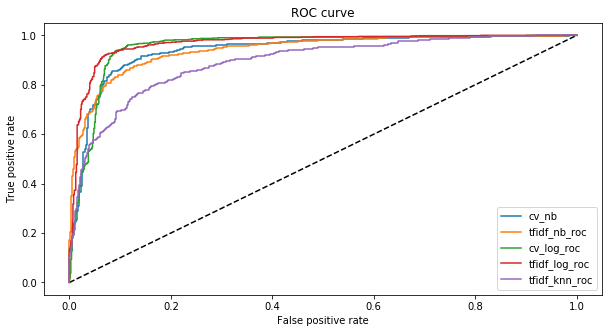

<Figure size 432x288 with 0 Axes>

In [99]:
# Evaluation

roc_data ={
    'cv_nb' : cv_nb_roc,
    'tfidf_nb_roc' : tfidf_nb_roc,
    'cv_log_roc' : cv_log_roc,
    'tfidf_log_roc' : tfidf_log_roc,
    'tfidf_knn_roc' : tfidf_knn_roc
}

#### Plot figure

plt.figure(1,figsize=(10,5))
plt.plot([0, 1], [0, 1], 'k--')
for key,roc in roc_data.items():
    plt.plot(roc[0], roc[1], label=key)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.savefig("./img/roc_curve.png",dpi=300)

The `crossvectorizer` + `logistic regression` model seems to perform similar to the `tfidf` vectorizer and `logistic regression` model. When looking at the accuracy score of all the models, the tfidf+ logistic regression model performs the best with an accuracy of 92% in terms of predicting if the selftext is either an r/confessions or r/relationships post.

### Save Best model weights

In [64]:
from joblib import dump, load
if __name__ == "__main__":
    model = tfidf_best_pipe.fit(X_text_train, y_text_train)
    dump(model, './model/tfidf_lr.joblib') 


